# 2.2 Demosaicing (30 + 40 + 20 = 90 points)
Nowadays cameras acquire color photographs by means of using a color filter array (CFA). The most common of such CFAs is the Bayer pattern (see Figure 1). In this configuration each pixel only senses one out of the three primary colors, hence discarding about two-third of the incoming light. The recovery of the missed color information in each pixel is called demosaicing and requires quite tricky image processing to avoid the introduction of unsightly color artifacts. <br>A reasonable approach is to reconstruct the green channel first, since it has the best spatial distribution of the three color channels and therefore is less subject to noise. After the green channel is finished one can employ its information to reconstruct the red and blue channel.

<center>
  <img width="668" height="169" src="./images/CFA.png">
   
<center>



Figure 1.The Bayer pattern with different mosaic patterns
[1](https://pixinsight.com/doc/tools/Debayer/Debayer.html)<br>

    
  


### Your Task is to implement the following functionalities:
> a) Realize demosaicing by nearest neighbor interpolation.<br>The straightforward method is to use the color information in a 2 × 2 neighborhood to restore the colors for all 4 pixels. This procedure is quite simple but has a severe drawback.<br> <br>
> b) Implement bilinear interpolation and compare it to nearest neighbor interpolation.<br>The most common interpolation type is bilinear interpolation. The basic scheme is to interpolate a missing pixel by averaging existing pixels in a 3 × 3- neighborhood first in one direction and then averaging the computed averages along the other direction.<br>

> __Hint:__ The provided helper function convolve2D can be used in the bilinear interpolation implementation.
    
> __Hint:__ All exercises should be implemented in functions taking the bayer pattern image as input and returning the demosaiced image, e.g. `image = function name(bayer)`. You don’t need to implement correct boundary handling, since the results are only differing in a few boundary pixels and the induced overhead is just too high.
    
> c) Compare visually and numerically.<br>Give a short description of the drawbacks / artifacts of the different algorithms and explain the problem
behind, e.g. why it happens. Use PSNR to measure the recovered image fidelity.



In [1]:
# Set path to your ppm folder TODO:
ppm_path = "./images"

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Helper functions:
def im2bayer(image: np.ndarray) -> np.ndarray:
    """Computes the bayer pattern given an image.
    Args:
        image:
            The input image to work on. Shape [H,W,3].
    Returns:
        The bayer pattern."""
   
   # image=(image/255).astype(float)
    bayer=np.zeros(image.shape)
    
    #RGGB pattern:
    for i in range(0,image.shape[0],2):
        for j in range(0,image.shape[1],2):
            bayer[i,j,0]=image[i,j,0]  #R
            
    for i in range(0,image.shape[0],2):
        for j in range(1,image.shape[1],2):
            bayer[i,j,1]=image[i,j,1]  #G
    
    for i in range(1,image.shape[0],2):
        for j in range(0, image.shape[1],2):
            bayer[i,j,1]=image[i,j,1]  #G
            
    for i in range(1, image.shape[0],2):
        for j in range(1, image.shape[1],2):       
            bayer[i,j,2]=image[i,j,2]  #B
  
    return bayer

def convolve2D(image: np.ndarray, kernel: np.ndarray, padding:int = 0, strides: int = 1) -> np.ndarray:
    """ Cross Correlation of the given image with the given kernel, equivalent to filter2D.
    Args:
        image:
            The input image to work on. Shape [H,W,3].
        kernel: 
            The kernel to be slided/convolved with over/with the image. Shape example here: [2,2,3]
    Returns:
        output:
            The convolved/2D filtered image."""
        
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding.
    x_kern_shape = kernel.shape[0]
    y_kern_shape = kernel.shape[1]
    x_img_shape = image.shape[0]
    y_img_shape = image.shape[1]

    # Shape of Output Convolution.
    x_output = int(((x_img_shape - x_kern_shape + 2 * padding) / strides) + 1)
    y_output = int(((y_img_shape - y_kern_shape + 2 * padding) / strides) + 1)
    output = np.zeros((x_output, y_output))

    # Apply Equal Padding to All Sides.
    if padding != 0:
        image_padded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        image_padded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        #print(imagePadded)
    else:
        image_padded = image

    # Iterate through image.
    for y in range(image.shape[1]):
        # Exit Convolution.
        if y > image.shape[1] - y_kern_shape:
            break
        # Only Convolve if y has gone down by the specified Strides.
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds.
                if x > image.shape[0] - x_kern_shape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides.
                    if x % strides == 0:
                        output[x, y] = (kernel * image_padded[x: x + x_kern_shape, y: y + y_kern_shape]).sum()
                except:
                    break

    return output


### a) Nearest Neighbor (30)
Realize demosaicing by _nearest neighbor_ interpolation.<br>The straightforward method is to use the color information in a 2 × 2 neighborhood to restore the colors for all 4 pixels.

__Hint:__ Take a look at the im2bayer function to figure out the CFA layout.

In [4]:
def nearest_neighbor(bayer):
    
    # Compute nearest neighbor color with sliding 2x2 window
    new_image = bayer.copy()
    for i in range(0,bayer.shape[0],2):
        for j in range(0,bayer.shape[1],2):
            # reconstruct red
            new_image[i+1,j,0] = bayer[i,j,0]
            new_image[i,j+1,0] = bayer[i,j,0]
            new_image[i+1,j+1,0] = bayer[i,j,0]

            # reconstruct green
            new_image[i,j,1] = (bayer[i,j+1,1] + bayer[i+1,j,1]) / 2
            new_image[i+1,j+1,1] = new_image[i,j,1]

            # reconstruct blue
            new_image[i,j,2] = bayer[i+1,j+1,2]
            new_image[i,j+1,2] = bayer[i+1,j+1,2]
            new_image[i+1,j,2] = bayer[i+1,j+1,2]

    return new_image.astype(np.uint8)

### b) Bilinear Interpolation (40)
Implement _bilinear interpolation_ and compare it to nearest neighbor interpolation.<br>The most common interpolation type is bilinear interpolation. The basic scheme is to interpolate a missing pixel by averaging existing pixels in a 3 × 3- neighborhood first in one direction and then averaging the computed averages along the other direction.


In [5]:
def bilinear(bayer):
    
    # Compute bilinear interpolation with sliding 3x3 window
    # Kernels from slides
    new_image = np.stack([convolve2D(bayer[:,:,0], np.array([[1,2,1],[2,4,2],[1,2,1]])/4,padding=1),
                          convolve2D(bayer[:,:,1], np.array([[0,1,0],[1,4,1],[0,1,0]])/4,padding=1),
                          convolve2D(bayer[:,:,2], np.array([[1,2,1],[2,4,2],[1,2,1]])/4,padding=1),
                        ], axis=-1)

    return new_image.astype(np.uint8)

### c) Comparison (20)
Compare visually and numerically.
Display all of your results: The image (ref), the computed bayer pattern, the nearest neighbor (nn) and bilinear interpolated results.
Calculate the psnr between the nn and image ref, and the bilinear and image ref and write out the result.

__Hint:__ Create a plot with subplots for each image and give them a title so you know what you are looking at.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR: 25.42862694873342


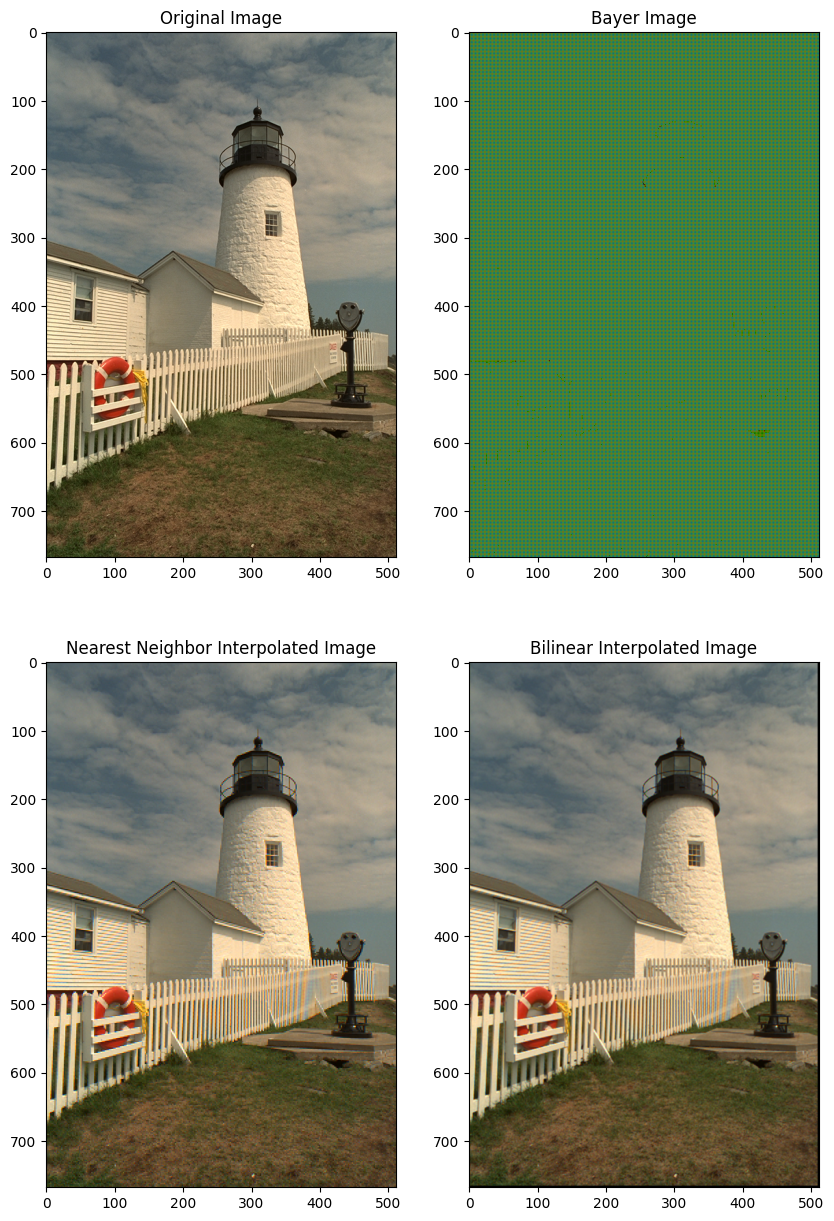

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 15))

# Read the image.
lighthouse = plt.imread(os.path.join(ppm_path, "lighthouse.ppm"))

# Display the image here:
ax[0,0].imshow(lighthouse)
ax[0,0].set_title("Original Image")

# Compute bayer image using the helper function:im2bayer and dispay the bayer image.
bayer = im2bayer(lighthouse)

# Display the bayer image.
ax[0,1].imshow(bayer)
ax[0,1].set_title("Bayer Image")

# Debayer the bayer image with nn interpolation method here:
nn = nearest_neighbor(bayer)

# Display the nn interpolated result here:
ax[1,0].imshow(nn)
ax[1,0].set_title("Nearest Neighbor Interpolated Image")

# Debayer the bayer image with bilinear interpolation method here.
bil = bilinear(bayer)

# Display the bilinear interpolated result.
ax[1,1].imshow(bil)
ax[1,1].set_title("Bilinear Interpolated Image")
 
# Calculate the psnr between the bilinar interpolated image and nearest neighbor interpolated image here.
from skimage.metrics import peak_signal_noise_ratio
psnr = peak_signal_noise_ratio(bil, nn)
print(f"PSNR: {psnr}")

#### Put your written answer here. What artifacts are visible and how can they be explained?

### Write down some explanation for the visual results.

We see false color effects with both methods, arising from the fine details of the fence where not enough image information is available. The artifact is also visible at the wall of the house. Since not all colors are available at every pixel, the interpolation results in false colors. The colors are computed from surrounding information which does not always match the true color. Especially when the pixel that we interpolate severely differs from the surrounding colors, as with the fine gaps in the fence.

When zooming into the images, we can also observe that the bilinear interpolation is smoother than the nearest neighbor interpolation. This is because the bilinear interpolation takes the average of the surrounding pixels, which results in a smoother image. The nearest neighbor interpolation, on the other hand, just copies the color of the nearest pixel, which can result in a more blocky image.